In [34]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

def convert_str_columns_to_lists(df):
    for col in df.columns:
        # Check if all non-null values look like a list in string form
        sample_vals = df[col].dropna().astype(str).head(10)
        if sample_vals.apply(lambda x: x.strip().startswith("[") and x.strip().endswith("]")).all():
            try:
                df[col] = df[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)
            except Exception as e:
                print(f"Could not convert column '{col}': {e}")
    return df

## logit lens: plot ffn & hidden

In [24]:
import re
def normalize(word):
    return re.sub(r'\W+', '', word).lower()  # Remove non-alphanumeric chars and lowercase

def get_retrieval_rates(results_df):
    token_str_cols = [col for col in results_df.columns if col.endswith("_top_token_str")]
    retrieval_rates = [] 
    layers = []

    for col in token_str_cols:
        pred_word = results_df[col].apply(lambda x: [normalize(word) for word in x])
        original_word = results_df["word"].apply(normalize)
        retrieval_match = pred_word.combine(original_word, lambda preds, orig: orig in preds)
        retrieval_rate = retrieval_match.mean()
        retrieval_rates.append(retrieval_rate)
        # Extract layer number from column name, e.g., "layer_1_top1_token_str" -> 1
        layer_num = int(col.split("_")[1])
        layers.append(layer_num)

    # Sort by layer number
    sorted_indices = sorted(range(len(layers)), key=lambda i: layers[i])
    layers = [layers[i] for i in sorted_indices]
    retrieval_rates = [retrieval_rates[i] for i in sorted_indices]
    
    return layers, retrieval_rates

def get_cumulative_retrieval_rates(results_df):
    layers = sorted([int(col.split("_")[1]) for col in results_df.columns if col.endswith("_top_token_str")])

    token_str_cols = [col for col in results_df.columns if col.endswith("_top_token_str")]
    token_str_cols = sorted(token_str_cols, key=lambda col: int(col.split("_")[1]))  # Ensure layers are ordered

    original_words = results_df["word"].apply(normalize)
    num_examples = len(original_words)

    cumulative_hits = [False] * num_examples
    cumulative_rates = []

    for col in token_str_cols:
        pred_words = results_df[col].apply(lambda x: [normalize(word) for word in x])
        retrieval_match = pred_words.combine(original_words, lambda preds, orig: orig in preds)
        # Update cumulative hits
        cumulative_hits = [prev or curr for prev, curr in zip(cumulative_hits, retrieval_match)]
        cumulative_rate = sum(cumulative_hits) / num_examples
        cumulative_rates.append(cumulative_rate)

    return layers, cumulative_rates

In [44]:
sns.set_palette("Set1")

def plot_retrieval_rates(MODEL_NAME, LANGUAGE, layers, retrieval_rates, ffn_layers, ffn_retrieval_rates, retreival_type="cumulative"):
    plt.figure(figsize=(8, 5))
    plt.plot(layers, retrieval_rates, marker='o', label='Layer Hidden States')
    plt.plot(ffn_layers, ffn_retrieval_rates, marker='o', label='FFN Hidden States')
    plt.xlabel("Layer")
    if retreival_type == "per_layer":
        plt.ylabel("Word Retrieval Rate (Top-3)")
        plt.title(f"Retrieval Rate per Layer ({MODEL_NAME}, {LANGUAGE})")
    elif retreival_type == "cumulative":
        plt.ylabel("Cumulative Retrieval Rate (Top-3)")
        plt.title(f"Cumulative Retrieval Rate ({MODEL_NAME}, {LANGUAGE})")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

In [45]:
def run_analysis(MODEL_NAME, LANGUAGE):
    # Load the dataframes
    # Adjust the paths as necessary
    layer_df = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordIdentity/single_token_simple_split_{MODEL_NAME}_{LANGUAGE}_v3.csv"
    ffn_df = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/ffn_hidden_states/single_token_simple_split_{MODEL_NAME}_{LANGUAGE}.csv"

    layer_df = pd.read_csv(layer_df)
    ffn_df = pd.read_csv(ffn_df)

    layer_df = convert_str_columns_to_lists(layer_df)
    ffn_df = convert_str_columns_to_lists(ffn_df)

    layers, retrieval_rates = get_retrieval_rates(layer_df)
    ffn_layers, ffn_retrieval_rates = get_retrieval_rates(ffn_df)

    layers, cumulative_rates = get_cumulative_retrieval_rates(layer_df)
    ffn_layers, ffn_cumulative_rates = get_cumulative_retrieval_rates(ffn_df)

    plot_retrieval_rates(MODEL_NAME, LANGUAGE, layers, retrieval_rates, ffn_layers, ffn_retrieval_rates, retreival_type="per_layer")
    plot_retrieval_rates(MODEL_NAME, LANGUAGE, layers, cumulative_rates, ffn_layers, ffn_cumulative_rates, retreival_type="cumulative")

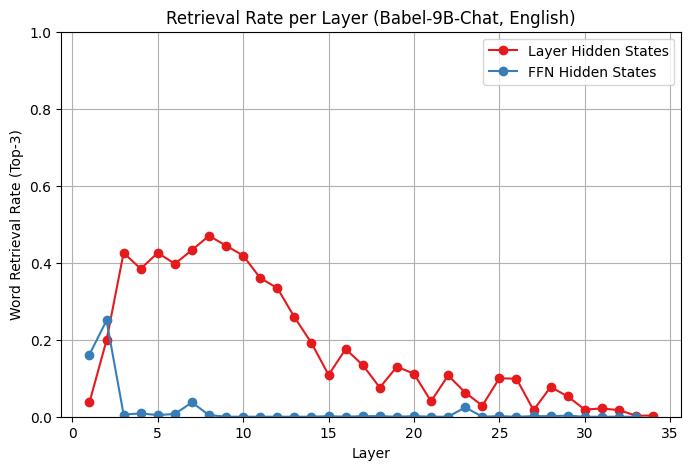

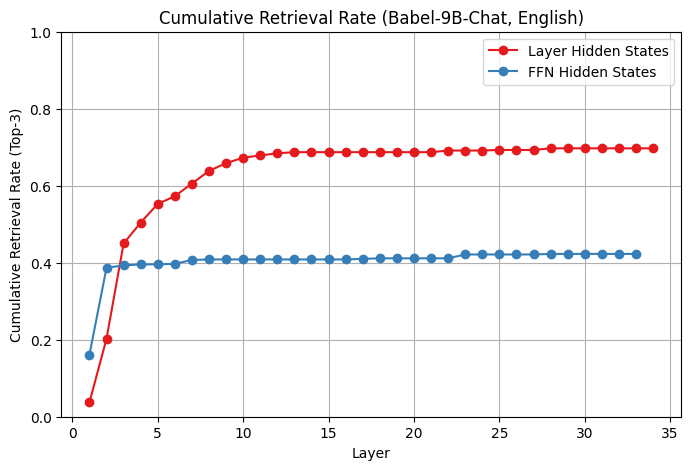

In [46]:
MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "English"

run_analysis(MODEL_NAME, LANGUAGE)

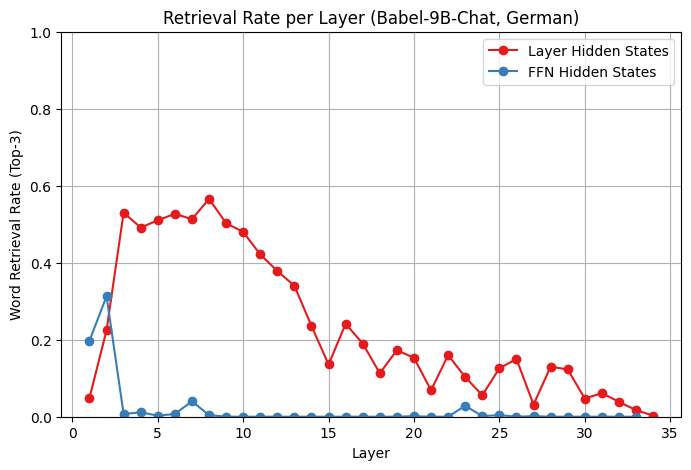

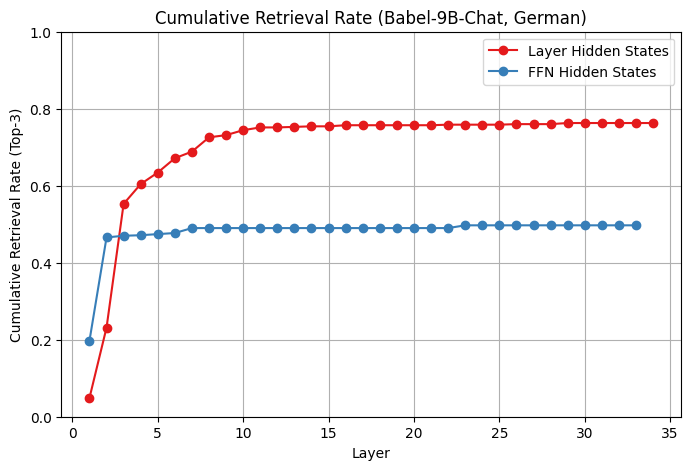

In [47]:
MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "German"

run_analysis(MODEL_NAME, LANGUAGE)

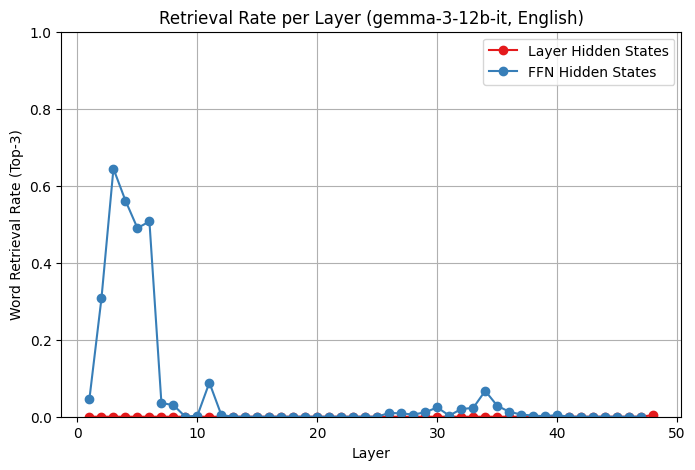

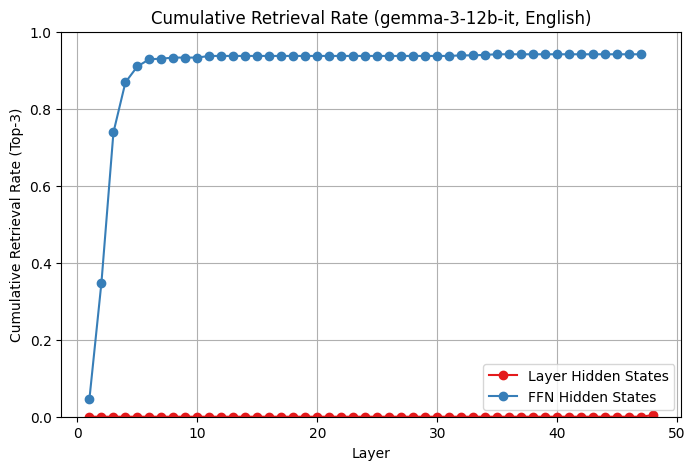

In [48]:
MODEL_NAME = "google/gemma-3-12b-it"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "English"

run_analysis(MODEL_NAME, LANGUAGE)

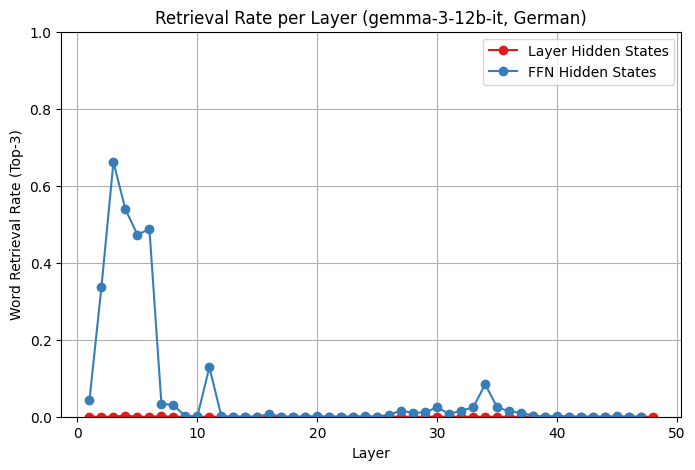

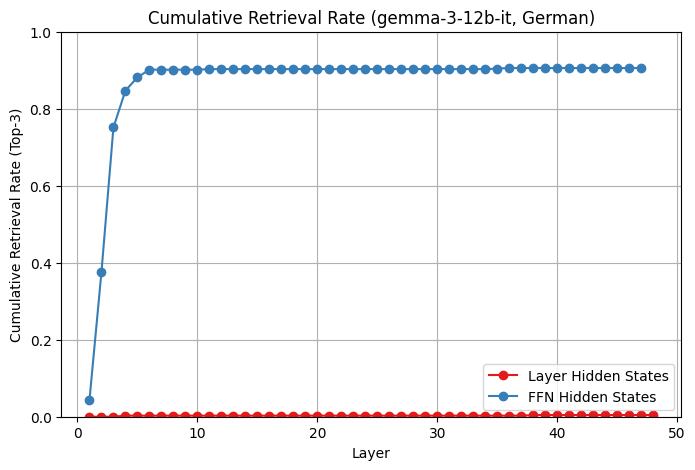

In [49]:
MODEL_NAME = "google/gemma-3-12b-it"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "German"

run_analysis(MODEL_NAME, LANGUAGE)

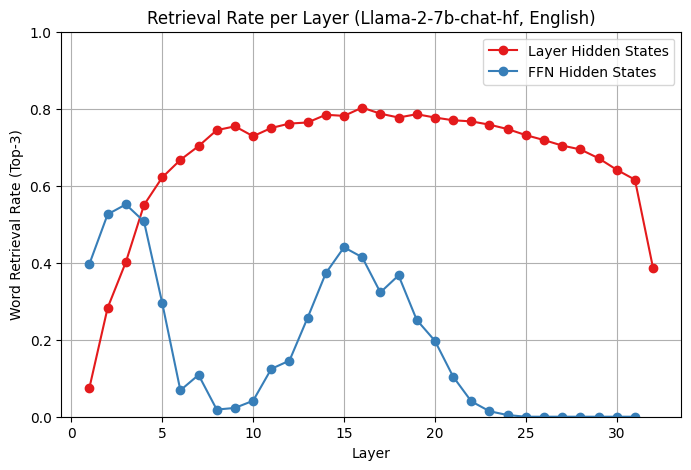

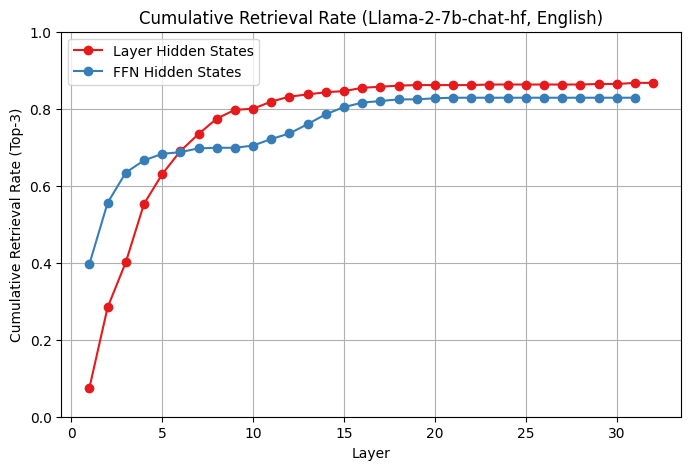

In [50]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "English"

run_analysis(MODEL_NAME, LANGUAGE)

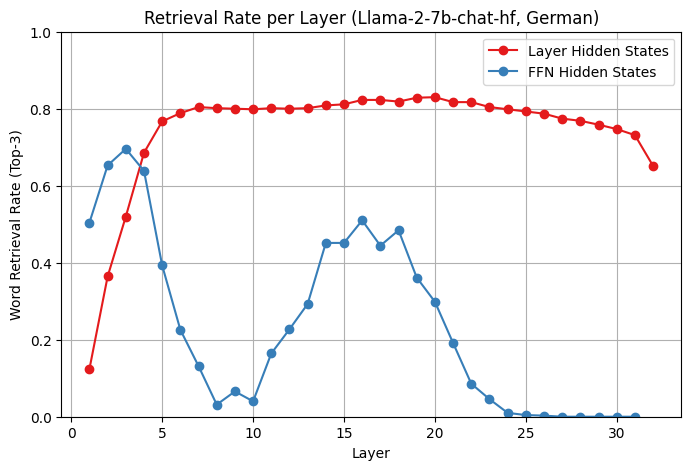

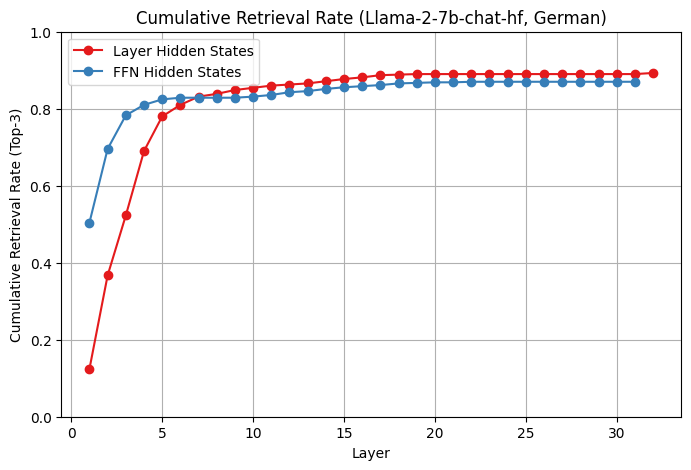

In [51]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "German"

run_analysis(MODEL_NAME, LANGUAGE)